# 딥러닝 활용한 sound classsification

## 1. 데이터 탐색

In [2]:
# Load imports

import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt

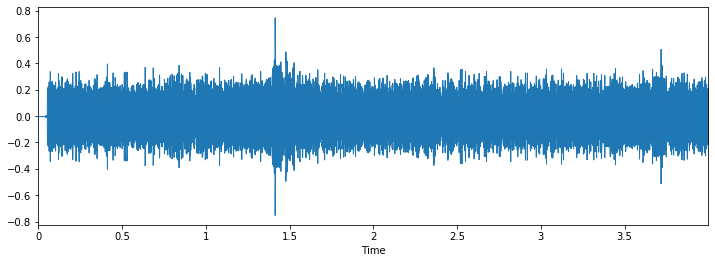

In [3]:
# Class: Air Conditioner

filename = '../UrbanSound Dataset sample/audio/100852-0-0-0.wav'
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)

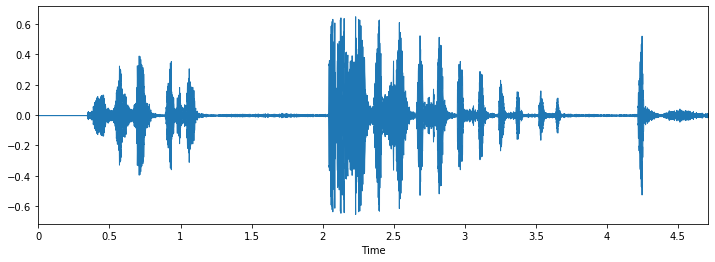

In [13]:
# Class: cough

filename = '../UrbanSound Dataset sample/audio/95.wav'
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)

##### 데이터셋 메타데이터: .csv 파일에 있는 정보를 pandas dataframe으로 변형

In [4]:
import pandas as pd
metadata = pd.read_csv('../UrbanSound Dataset sample/metadata/UrbanSound8K2.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class_name
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [5]:
len(metadata)

9232

##### 데이터로 사용된 클라스 보기

In [6]:
print(metadata.class_name.value_counts())

air_conditioner     1000
dog_bark            1000
engine_idling       1000
drilling            1000
children_playing    1000
street_music        1000
jackhammer          1000
siren                929
cough                500
car_horn             429
gun_shot             374
Name: class_name, dtype: int64


In [7]:
# import 필요한 라이브러리들
import pandas as pd
import os
import librosa
import librosa.display

from helpers.wavfilehelper import WavFileHelper
wavfilehelper = WavFileHelper()

audiodata = []
for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath('C:/Users/judy9/Desktop/UrbanSound8K/UrbanSound8K/audio/'),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    data = wavfilehelper.read_file_properties(file_name)
    audiodata.append(data)

# Convert into a Panda dataframe
audiodf = pd.DataFrame(audiodata, columns=['num_channels','sample_rate','bit_depth'])

In [11]:
import librosa 
from scipy.io import wavfile as wav
import numpy as np

filename = '../UrbanSound Dataset sample/audio/100852-0-0-0.wav' 

librosa_audio, librosa_sample_rate = librosa.load(filename) 
scipy_sample_rate, scipy_audio = wav.read(filename) 

print('Original sample rate:', scipy_sample_rate) 
print('Librosa sample rate:', librosa_sample_rate) 

Original sample rate: 44100
Librosa sample rate: 22050


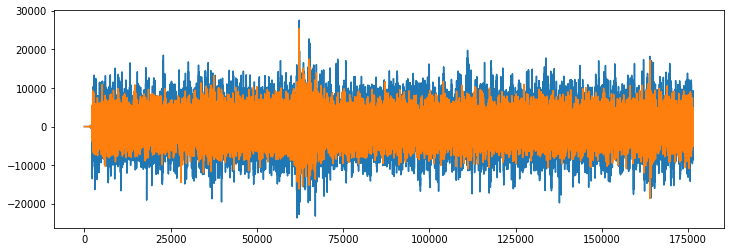

In [13]:
import matplotlib.pyplot as plt

# Original audio with 2 channels 
plt.figure(figsize=(12, 4))
plt.plot(scipy_audio)

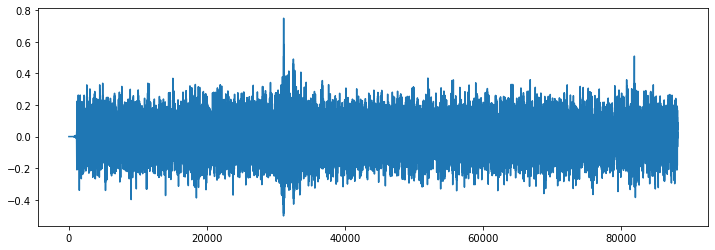

In [14]:
# Librosa audio with channels merged 
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio)

In [6]:
# mfcc의 shape 알아보기

In [15]:
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 173)


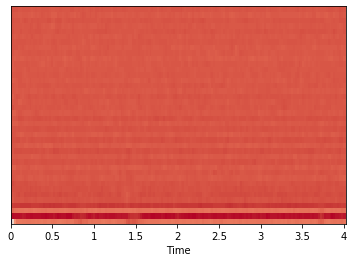

In [16]:
import librosa.display
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')

In [ ]:
#여기서부터

## 2. 특징 추출

In [59]:
import numpy as np
max_pad_len = 1000

def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None
    return mfccs

In [65]:
# Load various imports 
import pandas as pd
import os
import librosa
 
fulldatasetpath = 'C:/Users/judy9/Desktop/UrbanSound8K/UrbanSound8K/audio/'

metadata = pd.read_csv('../UrbanSound Dataset sample/metadata/UrbanSound8K2.csv')

features = []

# 각 사운드 파일 iterate 하면서 특징 추출하고 그에 상응하는 class 더하기
for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
    class_label = row["class_name"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files') 

Finished feature extraction from  9232  files


In [66]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# 특징과 레이블을 각각 X와 y로 넘파이 형태로 저장
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# 범주형으로 바꿈
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

In [67]:
# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

## 3. model 빌드 및 학습

In [69]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_rows = 40
num_columns = 1000
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

In [70]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [35]:
model.build()

In [71]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 39, 999, 16)       80        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 19, 499, 16)       0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 19, 499, 16)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 18, 498, 32)       2080      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 9, 249, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 9, 249, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 248, 64)      

In [93]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

#num_epochs = 12
#num_batch_size = 128

num_epochs = 10
num_batch_size = 512

checkpointer = ModelCheckpoint(filepath='saved_models/weights1109_4.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 7385 samples, validate on 1847 samples
Epoch 1/10
7385/7385 [==============================] - 110s 15ms/step - loss: 0.1810 - accuracy: 0.9385 - val_loss: 0.3389 - val_accuracy: 0.8977

Epoch 00001: val_loss improved from inf to 0.33893, saving model to saved_models/weights1109_4.best.basic_cnn.hdf5
Epoch 2/10
7385/7385 [==============================] - 111s 15ms/step - loss: 0.1752 - accuracy: 0.9425 - val_loss: 0.3321 - val_accuracy: 0.8955

Epoch 00002: val_loss improved from 0.33893 to 0.33210, saving model to saved_models/weights1109_4.best.basic_cnn.hdf5
Epoch 3/10
7385/7385 [==============================] - 112s 15ms/step - loss: 0.1857 - accuracy: 0.9372 - val_loss: 0.3284 - val_accuracy: 0.8966

Epoch 00003: val_loss improved from 0.33210 to 0.32840, saving model to saved_models/weights1109_4.best.basic_cnn.hdf5
Epoch 4/10
7385/7385 [==============================] - 124s 17ms/step - loss: 0.1791 - accuracy: 0.9384 - val_loss: 0.3183 - val_accuracy: 0.9020

Epoch 0

In [2]:
# loss가 크게 개선될 것 같지 않아 early stopping 했음

In [94]:
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9592416882514954
Testing Accuracy:  0.9014618396759033


## 4. 테스트

In [95]:
def print_prediction(file_name):
    prediction_feature = extract_features(file_name)
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)
    
    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector)
    print("The predicted class is:", predicted_class[0], '\n')
    
    predicted_proba_vector = model.predict_proba(prediction_feature)
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)):
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

In [3]:
# 테스트 : 예측 class 명과 확률을 나타냄

In [96]:
# Class: Air Conditioner

filename = '../UrbanSound Dataset sample/audio/100852-0-0-0.wav' 
print_prediction(filename) 

The predicted class is: air_conditioner 

air_conditioner 		 :  0.99456971883773803710937500000000
car_horn 		 :  0.00000052369011882547056302428246
children_playing 		 :  0.00053262745495885610580444335938
cough 		 :  0.00000000812464229227316536707804
dog_bark 		 :  0.00000238415373132738750427961349
drilling 		 :  0.00050123163964599370956420898438
engine_idling 		 :  0.00006791553460061550140380859375
gun_shot 		 :  0.00001402726411470212042331695557
jackhammer 		 :  0.00019526935648173093795776367188
siren 		 :  0.00003091799953836016356945037842
street_music 		 :  0.00408546021208167076110839843750


In [97]:
# Cough

filename = 'C:/Users/judy9/Downloads/013.wav' 
print_prediction(filename) 

The predicted class is: cough 

air_conditioner 		 :  0.00000061365767578536178916692734
car_horn 		 :  0.00000000457172966150665160967037
children_playing 		 :  0.01079356577247381210327148437500
cough 		 :  0.97955965995788574218750000000000
dog_bark 		 :  0.00840752013027667999267578125000
drilling 		 :  0.00000891896979737794026732444763
engine_idling 		 :  0.00000865612764755496755242347717
gun_shot 		 :  0.00000241962629843328613787889481
jackhammer 		 :  0.00000003991203101350038195960224
siren 		 :  0.00011226732021896168589591979980
street_music 		 :  0.00110644055530428886413574218750


In [98]:
# Class: Drilling

filename = '../UrbanSound Dataset sample/audio/103199-4-0-0.wav'
print_prediction(filename) 

The predicted class is: drilling 

air_conditioner 		 :  0.00000222715266318118665367364883
car_horn 		 :  0.00000150262019360525300726294518
children_playing 		 :  0.00000000446446968282998568611220
cough 		 :  0.00000000245021736233752562839072
dog_bark 		 :  0.00000007171327354171808110550046
drilling 		 :  0.99777299165725708007812500000000
engine_idling 		 :  0.00000000055302373791477066333755
gun_shot 		 :  0.00000000054057058829215520745493
jackhammer 		 :  0.00000006103594785145105561241508
siren 		 :  0.00000000007778364757848876820390
street_music 		 :  0.00222303951159119606018066406250


In [99]:
# Class: Street music 

filename = '../UrbanSound Dataset sample/audio/101848-9-0-0.wav'
print_prediction(filename) 

The predicted class is: street_music 

air_conditioner 		 :  0.00000471199564344715327024459839
car_horn 		 :  0.00001536592935735825449228286743
children_playing 		 :  0.00012767793668899685144424438477
cough 		 :  0.00000383916039936593733727931976
dog_bark 		 :  0.00002895280340453609824180603027
drilling 		 :  0.00000025624282784519891720265150
engine_idling 		 :  0.00000007916607103197748074308038
gun_shot 		 :  0.00000000000000000136437827552214
jackhammer 		 :  0.00000003767410916566404921468347
siren 		 :  0.00002805249459925107657909393311
street_music 		 :  0.99979108572006225585937500000000


In [100]:
# Class: Car Horn 

filename = '../UrbanSound Dataset sample/audio/100648-1-0-0.wav'
print_prediction(filename) 

The predicted class is: gun_shot 

air_conditioner 		 :  0.00446089264005422592163085937500
car_horn 		 :  0.09738751500844955444335937500000
children_playing 		 :  0.02447767555713653564453125000000
cough 		 :  0.03261497989296913146972656250000
dog_bark 		 :  0.21655111014842987060546875000000
drilling 		 :  0.15650747716426849365234375000000
engine_idling 		 :  0.01563415303826332092285156250000
gun_shot 		 :  0.32801687717437744140625000000000
jackhammer 		 :  0.08034669607877731323242187500000
siren 		 :  0.03396245464682579040527343750000
street_music 		 :  0.01004011090844869613647460937500


In [101]:
# Cough

filename = 'C:/Users/judy9/Downloads/cough.wav' 
print_prediction(filename) 

The predicted class is: cough 

air_conditioner 		 :  0.00000000001370511256565398738871
car_horn 		 :  0.00000000000088136458851681420690
children_playing 		 :  0.00002096581738442182540893554688
cough 		 :  0.99997723102569580078125000000000
dog_bark 		 :  0.00000064151419110203278250992298
drilling 		 :  0.00000000002419844880030552758399
engine_idling 		 :  0.00000000002508726559824481228134
gun_shot 		 :  0.00000000000262666537825806400974
jackhammer 		 :  0.00000000000000003141840746863007
siren 		 :  0.00000009663521183256307267583907
street_music 		 :  0.00000105030221675406210124492645


In [102]:
# Cough

filename = 'C:/Users/judy9/Desktop/UrbanSound8K/UrbanSound8K/audio/fold5/42.wav' 
print_prediction(filename) 

The predicted class is: cough 

air_conditioner 		 :  0.00000000000000884708041011929638
car_horn 		 :  0.00000000000000000027310590599781
children_playing 		 :  0.00007783769979141652584075927734
cough 		 :  0.99680787324905395507812500000000
dog_bark 		 :  0.00307209021411836147308349609375
drilling 		 :  0.00000000000001740792297637294705
engine_idling 		 :  0.00000000000183950099076624074002
gun_shot 		 :  0.00000000000259089776542820171557
jackhammer 		 :  0.00000000000000000000006678507152
siren 		 :  0.00000000769197061600834786077030
street_music 		 :  0.00004221900962875224649906158447


In [103]:
# Cough

filename = 'C:/Users/judy9/Desktop/my.wav' 
print_prediction(filename) 

The predicted class is: cough 

air_conditioner 		 :  0.00000000657784005042572061938699
car_horn 		 :  0.00000000000005404859638189277171
children_playing 		 :  0.00000149547349792555905878543854
cough 		 :  0.99913460016250610351562500000000
dog_bark 		 :  0.00011733776045730337500572204590
drilling 		 :  0.00000005496706734220424550585449
engine_idling 		 :  0.00000000000144676653469899552107
gun_shot 		 :  0.00000000000011069214934846666187
jackhammer 		 :  0.00000000000000001905891794696283
siren 		 :  0.00000000055949667121524271351518
street_music 		 :  0.00074652337934821844100952148438


In [4]:
# end of cough data preprocesing & training/testing